In [123]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [124]:
# FUNCTION: 
# Example call:   tf_variable = get_nn_parameter(...)
def get_nn_parameter(variable_scope, variable_name, dim1, dim2):
    '''
    Used to retrieve or create new NN parameters (weights & biases)
    When calling, the corresponding NNparameter's dimensions need to be specified too.
    Returns a tensorflow variable. Note that NN parameters need to be tensorflow variables
    so that values can be changed whenever needed when training. Also note that it is 
    explicitly defined that the created variable is TRAINABLE.
    '''
    with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
      v = tf.get_variable(variable_name, 
                          [dim1, dim2], 
                          trainable=True, 
                          initializer = tf.contrib.layers.xavier_initializer())
    return v

In [125]:
# FUNCTION: 
# Example call:   nn_parameters = initialize_layer_parameters([3, 5, 5, 2])
def initialize_layer_parameters(num_units_in_layers):
    '''
    NOTE THAT THE LAST LAYER HAS TO HAVE AT LEAST 2 UNITS BCZ SOFTMAX IS USED IN THIS NN MODEL
    Returns a dictionary of created weights and biases for all layers of the NN.
    Note that # units can vary in each layer.
    Exmaple return: parameters = {"W1": tf_variable_for_W1, "b1": tf_variable_for_b1, ...}
    '''
    
    parameters = {}
    L = len(num_units_in_layers)
     
    for i in range (1, L):
        #print("W" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(num_units_in_layers[i-1]))
        temp_weight = get_nn_parameter("weights",
                                       "W"+str(i), 
                                       num_units_in_layers[i], 
                                       num_units_in_layers[i-1])
        parameters.update({"W" + str(i) : temp_weight})  
        
        #print("b" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(1))
        temp_bias = get_nn_parameter("biases",
                                     "b"+str(i), 
                                     num_units_in_layers[i], 
                                     1)
        parameters.update({"b" + str(i) : temp_bias})  
        
    return parameters

In [126]:
# FUNCTION: 
# Example call: ZL = forward_propagation_with_relu(X_train, [3, 5, 5, 2], nn_parameters)
def forward_propagation_with_relu(X, num_units_in_layers, parameters):
    '''
    Returns ZL, which is the linear output of the output layer (layer L)
    AL is also calculated but it is not returned or used. The optimizer function takes ZL as input, not the AL.
    What activation function is used in output layer plays role when calculating the cost 
    so that you need to call the right cost (or cross entropy) function in compute_cost(...) function
    '''
    L = len(num_units_in_layers)
    
    A_temp = tf.transpose(X)
    for i in range (1, L):
        #W = get_nn_parameter("weights", "W"+str(i), num_units_in_layers[i], num_units_in_layers[i-1])
        W = parameters.get("W"+str(i))
        #b = get_nn_parameter("biases", "b"+str(i), num_units_in_layers[i], 1)
        b = parameters.get("b"+str(i))
        Z_temp = tf.add(tf.matmul(W, A_temp), b)
        A_temp = tf.nn.relu(Z_temp)       # Example: A1 = relu(Z1)1, Note that A in the last (output) 
                                          # layer is irrelevant bcz we return ZL

    return Z_temp   #This is the linear output of last layer

In [127]:
# FUNCTION
# This function requires update if softmax is not used in the output layer
def compute_cost(ZL, Y, parameters, lambd, mb_size):
    """
    This function should be used for multinomial mutually exclusive classification, i.e. pick one out of N classes. 
    Also applicable when N = 2.
    The labels must be one-hot encoded or can contain soft class probabilities: a particular example can belong to
    class A with 50% probability and class B with 50% probability. Note that strictly speaking it doesn't mean that
    it belongs to both classes, but one can interpret the probabilities this way.
    
    Arguments:
    ZL -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as ZL
    mb_size -- number of samples in the given mini-batch
    lambd -- lambda regularization parameter (regularization deactivated is lambd=0.)
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(ZL)
    labels = Y
    
    # This cost calculation is unregularized. cost = (1/m) sum(Loss(y_hat(i), y(i))), where i = 1,..,mb_size 
    #tf.reduce_mean(..) function finds the mean of costs of examples in the given mini-batch
    cost_unregularized = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    
    # Add L2 regularization: cost += (lambd / (2 * mb_size)) * sum(W(i,j)**2), where i:1,..,n[l] and j:1,..,n[l-1] 
    # L:number of layers. Since the dict parameters includes both W and b, it needs to be divided with 2 to find L
    L = len(parameters) // 2
    
    # The list will have L elements, each holding the sum of weight matrix values in each layer. Later, these
    # weight values need to be summed up again
    list_sum_weights = []
    
    for i in range (0, L):
        list_sum_weights.append(tf.nn.l2_loss(parameters.get("W"+str(i+1))))
    
    # in the following calculation, since the l2_loss returns "sum(t ** 2) / 2", where the sum of squares is already
    # divided by 2, there is no need to bultiply the mb_size with 2
    #regularization_effect = (lambd / mb_size) * sum(list_sum_weights)
    regularization_effect = tf.multiply((lambd / mb_size), tf.add_n(list_sum_weights))
    cost = tf.add(cost_unregularized, regularization_effect)
    
    return cost

In [128]:
# Note that 4 statements below need to updated prior to any use in any project because number of columns 
# (# features and labels) may change in each project

# This function only uses tf.TextLineReader(...) and does not read other types of files i.e. binary files
def get_next_mini_batch(mini_batch_size, num_epochs, input_paths, shuffle):

    # string_input_producer creates a FIFO queue for holding the filenames until the reader needs them
    filename_queue = tf.train.string_input_producer(input_paths,
                                                    num_epochs,
                                                    shuffle)

    # Select the type of reader that will be used to read the CSV files down below.
    reader = tf.TextLineReader(skip_header_lines=1)

    # reader.read(..) just reads 1 row at a time
    key, value = reader.read(filename_queue)

    # UPDATE-1 IN EACH PROJECT (depending on default values for each column)
    # Determine default values for each column in case data is missing
    record_defaults = [[""], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

    # UPDATE-2 IN EACH PROJECT (depending on #columns)
    # The decode_csv op parses the result of reader.read_up_to(...) into a list of tensors.
    # For instance, col2 below is a list of tensors.
    col1, col2, col3, col4, col5, col6, col7, col8 = tf.decode_csv(value, record_defaults)

    # UPDATE-3-4 (FINAL) IN EACH PROJECT (depending on # features & labels)
    # define which columns constitute features and which columns are labels and stack them together
    features = tf.stack([col2, col3, col4, col5, col6])
    labels = tf.stack([col7, col8])


    min_after_dequeue = mini_batch_size * 3
    capacity = min_after_dequeue + 10 * mini_batch_size

    X_mini_batch, Y_mini_batch = tf.train.shuffle_batch([features, labels], 
                                                        batch_size=mini_batch_size, 
                                                        capacity=capacity,
                                                        min_after_dequeue = min_after_dequeue,
                                                        allow_smaller_final_batch = True)
    
    return X_mini_batch, Y_mini_batch

In [134]:
def nn_model(train_input_paths, X_test, Y_test, learning_rate, num_epochs,
             minibatch_size, num_units_in_layers, lambd, print_cost):
    """
    Returns NN parameters after the completion of training.
    """
    
    tf.reset_default_graph()     # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)       # tf.reset_default_graph() needs to be run first before calling tf.set_random_seed(..)
    
    costs = []                                        # To keep track of the cost
    
    # To be used to get the next mini batch during the training
    X_mini_batch, Y_mini_batch = get_next_mini_batch(minibatch_size, 
                                                     num_epochs, 
                                                     train_input_paths, 
                                                     True)
    
    # To be used to get the next mini batch when calculating/evaluating accuracy
    X_eval_batch, Y_eval_batch = get_next_mini_batch(minibatch_size, 
                                                     1,                     # Only run through dataset once
                                                     train_input_paths, 
                                                     False)                 # Do NOT shuffle when calculating accuracy
    
    # Initialize parameters
    parameters = initialize_layer_parameters(num_units_in_layers)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ZL = forward_propagation_with_relu(X_mini_batch, num_units_in_layers, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(ZL, Y_mini_batch, parameters, lambd, 
                        mb_size=tf.cast(X_mini_batch.shape[1], dtype=tf.float32))
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init_global_var = tf.global_variables_initializer() 
    init_local_var = tf.local_variables_initializer()   
    
    with tf.Session() as sess:
        
      sess.run(init_global_var)
      # initializing local variables needed to be able to set num_epochs
      sess.run(init_local_var)

      # Start populating the filename queue.
      # tf.train.start_queue_runners(...) needs to be called before populating the queue ...
      # before you call run or eval to execute the read
      coord = tf.train.Coordinator()
      threads = tf.train.start_queue_runners(sess=sess, coord=coord)

      cost_of_model = 0
      nr_of_minibatches = 0
      try:
        while not coord.should_stop():
          _ , minibatch_cost = sess.run([optimizer, cost])
            
          nr_of_minibatches += 1
          cost_of_model += minibatch_cost
          cost_of_model /= nr_of_minibatches
        
          # Print the cost every epoch
          if print_cost == True and nr_of_minibatches % 30 == 0:
              print ("Cost after minibatch %i: %f" % (nr_of_minibatches, cost_of_model))
          if print_cost == True and nr_of_minibatches % 5 == 0:
              costs.append(cost_of_model)  
      except tf.errors.OutOfRangeError:
        print('Done training, epoch reached')
      finally:
        coord.request_stop()
        print("bitti")
        coord.join(threads)
    
      # plot the cost
      plt.plot(np.squeeze(costs))
      plt.ylabel('cost')
      plt.xlabel('iterations (per tens)')
      plt.title("Learning rate =" + str(learning_rate))
      plt.show()
    
      # lets save the parameters in a variable
      parameters = sess.run(parameters)

    with tf.Session() as sess2:
    
      sess2.run(init_global_var)
      # initializing local variables needed to be able to set num_epochs
      sess2.run(init_local_var)
    
      coord2 = tf.train.Coordinator()
      threads2 = tf.train.start_queue_runners(sess=sess2, coord=coord2)
      correct_prediction = []
      try:
        i = 1
        num_epochs = 1
        while not coord2.should_stop():
        
          # Do NOT shuffle the training data when calculating accuracy
          X_e_batch, Y_e_batch = sess2.run([X_eval_batch, Y_eval_batch])
          print("i:" + str(i))
          print(X_e_batch)
          print(Y_e_batch)
          i += 1
          # Calculate the correct predictions
          correct_prediction.append(tf.equal(tf.argmax(sess2.run(ZL, feed_dict={X_mini_batch: X_e_batch}), axis=0),
                                             tf.argmax(tf.transpose(Y_e_batch), axis=0)))
          
      except tf.errors.OutOfRangeError:
        print('Calculation of Accuracy completed')
      finally:
        coord2.request_stop()
        coord2.join(threads2)
      
      #flatten the correct_prediction matrix so that tf.reduce_mean function can use it to calculate accuracy
      correct_prediction = tf.reshape(correct_prediction, [-1])
      train_accuracy = tf.reduce_mean(sess2.run(tf.cast(correct_prediction, dtype=tf.float32)))
      # Calculate accuracy on the test set
      print ("Train Accuracy:", sess2.run(train_accuracy))
        
    return parameters, train_accuracy

Cost after minibatch 30: 0.012748
Cost after minibatch 60: 0.009848
Done training, epoch reached
bitti


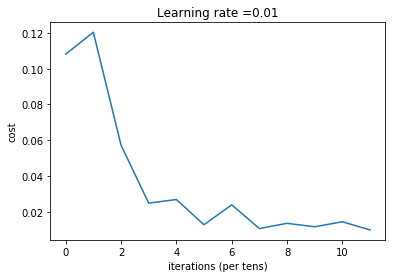

i:1
[[-1.  2.  3.  8.  5.]
 [ 1.  5.  8.  3.  3.]
 [ 9.  8.  7.  4.  2.]
 [ 4.  7.  2.  3.  8.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
i:2
[[3. 5. 6. 9. 4.]
 [4. 6. 3. 4. 3.]
 [3. 2. 8. 9. 1.]
 [5. 5. 5. 5. 5.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
i:3
[[ 1.  5.  4.  2.  7.]
 [-4.  2.  9.  4.  5.]
 [ 7.  7.  7.  7.  7.]
 [ 9.  9.  9.  9.  9.]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
i:4
[[ 6.  3.  7.  8.  4.]
 [11. 11. 11. 11. 11.]
 [ 2.  2.  2.  2.  2.]
 [13. 13. 13. 13. 13.]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
i:5
[[ 6.  6.  6.  6.  6.]
 [10. 10. 10. 10. 10.]
 [ 3.  3.  3.  3.  3.]
 [14. 14. 14. 14. 14.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
i:6
[[ 4.  4.  4.  4.  4.]
 [12. 12. 12. 12. 12.]
 [ 8.  8.  8.  8.  8.]
 [ 1.  1.  1.  1.  1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Calculation of Accuracy completed
Train Accuracy: 0.5833333


In [135]:
# X/Y_train and X/Y_test need to be replaced with file paths
X_train = np.array([[-1.,4.,-7.],[2.,6.,2.],[3.,3.,9.],[8.,4.,4.],[5.,3.,5.]])
Y_train = np.array([[1., 1., 1.], [0., 0., 0.]])
X_test = np.array([[2.,3.],[3.,4.],[1.,2.],[4.,5.],[7.,8.]])
Y_test = np.array([[1.],[0.]])
learning_rate = 0.01 
num_epochs = 10
minibatch_size = 4     # m % minibatch_size needs to be 0. otherwise, tf.reshape function crashing 
num_units_in_layers = [5,4,3,2] 
lambd = 0. 
print_cost = True

# Data may reside in several files. 2 is created here for illustration purposes
train_path1 = "train1.csv"
train_path2 = "train2.csv"
train_input_paths = [train_path1, train_path2]

parameters, train_accuracy = nn_model(train_input_paths, X_test, Y_test, learning_rate, num_epochs,
                                      minibatch_size, num_units_in_layers, lambd, print_cost)



In [40]:
#TODO
# Implement using CSV file(s) even for test data
# Split data into train, dev, test sets (maybe by using tf.Split(...) function) while still supporting csv files
# Save NN parameters somewhere after (How?)
# Add batch normalization   (check what needs to be done for gradient calculations)
# Dropout

abc = []
abc.append(1)
abc.append(5)
print(abc)
print(sum(abc))

[1, 5]
6


In [ ]:
der = np.array([3,3,3])
print(len(der))